# Turtle trading agent

https://thecitadelpub.com/making-money-with-algo-trading-for-dummies-the-turtle-trading-agent-3b1febe685df

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df = pd.read_csv('../dataset/BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-25,9539.485352,9704.556641,9530.211914,9677.113281,9677.113281,1.661007e+10
1,2020-07-26,9680.234375,10023.807617,9652.847656,9905.166992,9905.166992,2.050800e+10
2,2020-07-27,9905.217773,11298.221680,9903.969727,10990.873047,10990.873047,3.535975e+10
3,2020-07-28,11017.463867,11204.327148,10632.631836,10912.823242,10912.823242,2.876655e+10
4,2020-07-29,10912.953125,11304.397461,10856.141602,11100.467773,11100.467773,2.461725e+10


In [3]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,9677.113281,NaN,NaN
1,0.0,9905.166992,NaN,NaN
2,0.0,10990.873047,NaN,NaN
3,0.0,10912.823242,NaN,NaN
4,0.0,11100.467773,NaN,NaN
...,...,...,...,...
361,0.0,32110.693359,40406.269531,29807.347656
362,0.0,32313.105469,40406.269531,29807.347656
363,0.0,33581.550781,38347.062500,29807.347656
364,0.0,34292.445313,38053.503906,29807.347656


In [5]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 1000000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [6]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 40: buy 1 units at price 10245.296875, total balance 989754.703125
day 42: buy 1 units at price 10169.567383, total balance 979585.135742
day 45: buy 1 units at price 10131.516602, total balance 969453.619140
day 118, sell 1 units at price 18621.314453, investment 83.795923 %, total balance 988074.933593,
day 119, sell 1 units at price 18642.232422, investment 84.002387 %, total balance 1006717.166015,
day 122, sell 1 units at price 19107.464844, investment 88.594320 %, total balance 1025824.630859,
day 128: cannot sell anything, inventory 0
day 144: cannot sell anything, inventory 0
day 145: cannot sell anything, inventory 0
day 146: cannot sell anything, inventory 0
day 147: cannot sell anything, inventory 0
day 153: cannot sell anything, inventory 0
day 154: cannot sell anything, inventory 0
day 156: cannot sell anything, inventory 0
day 157: cannot sell anything, inventory 0
day 158: cannot sell anything, inventory 0
day 159: cannot sell anything, inventory 0
day 160: cannot se

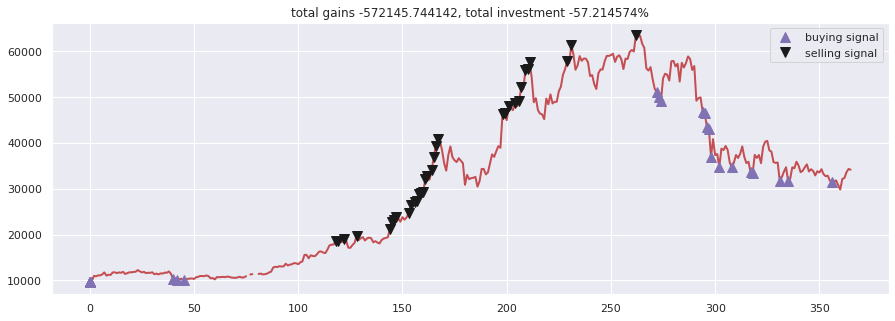

In [7]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()